# Capstone Project - The Battle of Neighborhoods

## Table of Contents
- [Introduction](#Introduction)
- [Data](#Data)
- [Methodology](#Methodology)
- [Results](#Results)
- [Discussion](#Discussion)
- [Conclusion](#Conclusion)

## Introduction

In this project, we build a predictive model of sale price for the real properties in Manhattan, New York City, USA. 
Such predictive models would be helpful to anyone who is interested in housing price prediction, such as sellers, buyers and agents of real estate.

Prediction is not our only purpose. We also try to interpret what are the important factors that affect the price, and how the resulting model makes the prediction. This will help those interested people on their decision making.

## Data

What are the factors that may affect the sale price of real properties? What kind of data are available for us to build the predictive model? In this project, we use the data mainly from three sources: 
1. [Property Sales Data](https://www1.nyc.gov/assets/finance/downloads/pdf/rolling_sales/annualized-sales/2018/2018_manhattan.xlsx) from NYC government website
2. Lat & Lng Data retrieved by [Geocoder](https://geocoder.readthedocs.io/) from [OpenStreetMap](https://nominatim.openstreetmap.org/)
3. Neighborhood Venue Data from [Foursquare](https://developer.foursquare.com/)

For Property Sales Data, we use the set of last year (2018), including all the transactions in Manhattan, 2018. The columns of the data are different features of each transaction: borough, street address, tax class, sale price, etc. The sale price is our prediction target.

Beside the information in Property Sales Data, there are also other factors that may affect the price, for example, nearby venues around the real property. Foursquare is a good choice of retrieving venue information. To utilize the venue information, we first map the street address in Property Sales Data to the geographical coordinate using Lat & Lng Data extracted by Geocoder, and then scrap the nearby venues from Foursquare using the Lat & Lng Data of the property.

In next sections, we show how to preprocess these datasets and prepare the training data for building the predictive model.

## Methodology

We first preprocess Property Sales Data, Lat & Lng Data and Neighborhood Venue Data, and then prepare training data based on these three datasets. Once the training data is ready, we build our model for housing price prediction, and evaluate its predictive performance. Finally, we interpret the resulting model to see what are important factors that affect the housing price in Manhattan.

Let's start with importing necessary modules.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from geopy.geocoders import Nominatim
import requests

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import plot_partial_dependence

Retrive the original excel file of Property Sales Data from NYC government website. Specifically, we use the data of housing price in Manhattan, 2018.

In [2]:
df = pd.read_excel(
    'https://www1.nyc.gov/assets/finance/downloads/pdf/rolling_sales/annualized-sales/2018/2018_manhattan.xlsx', header=4)
print(df.shape)
df.head()

(17041, 21)


,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AS OF FINAL ROLL 18/19,BLOCK,LOT,EASE-MENT,BUILDING CLASS AS OF FINAL ROLL 18/19,ADDRESS,APARTMENT NUMBER,...,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,1,ALPHABET CITY,01 ONE FAMILY DWELLINGS,1,390,61,NaN,A4,189 EAST 7TH STREET,NaN,...,1.0,0.0,1.0,987.0,2183.0,1860,1,A4,0,2018-05-23
1,1,ALPHABET CITY,01 ONE FAMILY DWELLINGS,1,390,61,NaN,A4,189 EAST 7TH STREET,NaN,...,1.0,0.0,1.0,987.0,2183.0,1860,1,A4,4844809,2018-05-22
2,1,ALPHABET CITY,01 ONE FAMILY DWELLINGS,1,400,19,NaN,A4,526 EAST 5TH STREET,NaN,...,1.0,0.0,1.0,1883.0,5200.0,1900,1,A4,6100000,2018-12-03
3,1,ALPHABET CITY,02 TWO FAMILY DWELLINGS,1,390,35,NaN,B1,113 AVENUE C,NaN,...,2.0,0.0,2.0,1218.0,4764.0,1899,1,B1,0,2018-04-25
4,1,ALPHABET CITY,02 TWO FAMILY DWELLINGS,1,404,1,NaN,B9,166 AVENUE A,NaN,...,2.0,0.0,2.0,1510.0,4520.0,1900,1,B9,0,2018-11-29


Have a look at the summary of statistics of this dataset.

In [3]:
df.describe()

,BOROUGH,BLOCK,LOT,EASE-MENT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,SALE PRICE
count,17041.0,17041.000000,17041.000000,0.0,17041.000000,17040.000000,17040.000000,17040.000000,17040.000000,1.704000e+04,17041.000000,17041.000000,1.704100e+04
mean,1.0,1132.106214,733.622205,NaN,10013.777478,1.831573,0.370188,2.324413,3845.752465,3.874125e+03,1703.432193,2.128514,3.084401e+06
std,0.0,527.064183,905.585447,NaN,400.539840,13.173900,4.552559,14.296666,12263.810136,2.859874e+04,651.120981,0.553508,2.727683e+07
min,1.0,2.000000,1.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,1.000000,0.000000e+00
25%,1.0,797.000000,29.000000,NaN,10013.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,1910.000000,2.000000,9.001000e+04
50%,1.0,1171.000000,1002.000000,NaN,10022.000000,0.000000,0.000000,1.000000,0.000000,5.060000e+02,1931.000000,2.000000,8.000000e+05
75%,1.0,1469.000000,1186.000000,NaN,10028.000000,1.000000,0.000000,1.000000,1197.500000,1.306000e+03,1973.000000,2.000000,1.825000e+06
max,1.0,2250.000000,9101.000000,NaN,10463.000000,597.000000,259.000000,601.000000,191502.000000,1.133549e+06,2018.000000,4.000000,2.397502e+09


Because the column of "EASE-MENT" is full of NaN, let's simply drop it. We also drop the column of "APARTMENT NUMBER" because it seems to depend on a specific building and is not related to housing price.

In [4]:
df.drop(columns=['EASE-MENT\n', 'APARTMENT NUMBER\n'], inplace=True)
print(df.shape)
df.head()

(17041, 19)


,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AS OF FINAL ROLL 18/19,BLOCK,LOT,BUILDING CLASS AS OF FINAL ROLL 18/19,ADDRESS,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,1,ALPHABET CITY,01 ONE FAMILY DWELLINGS,1,390,61,A4,189 EAST 7TH STREET,10009,1.0,0.0,1.0,987.0,2183.0,1860,1,A4,0,2018-05-23
1,1,ALPHABET CITY,01 ONE FAMILY DWELLINGS,1,390,61,A4,189 EAST 7TH STREET,10009,1.0,0.0,1.0,987.0,2183.0,1860,1,A4,4844809,2018-05-22
2,1,ALPHABET CITY,01 ONE FAMILY DWELLINGS,1,400,19,A4,526 EAST 5TH STREET,10009,1.0,0.0,1.0,1883.0,5200.0,1900,1,A4,6100000,2018-12-03
3,1,ALPHABET CITY,02 TWO FAMILY DWELLINGS,1,390,35,B1,113 AVENUE C,10009,2.0,0.0,2.0,1218.0,4764.0,1899,1,B1,0,2018-04-25
4,1,ALPHABET CITY,02 TWO FAMILY DWELLINGS,1,404,1,B9,166 AVENUE A,10009,2.0,0.0,2.0,1510.0,4520.0,1900,1,B9,0,2018-11-29


Let's check the column names.

In [5]:
df.columns

Index(['BOROUGH\n', 'NEIGHBORHOOD\n', 'BUILDING CLASS CATEGORY\n',
       'TAX CLASS AS OF FINAL ROLL 18/19', 'BLOCK\n', 'LOT\n',
       'BUILDING CLASS AS OF FINAL ROLL 18/19', 'ADDRESS\n', 'ZIP CODE\n',
       'RESIDENTIAL UNITS\n', 'COMMERCIAL UNITS\n', 'TOTAL UNITS\n',
       'LAND SQUARE FEET\n', 'GROSS SQUARE FEET\n', 'YEAR BUILT\n',
       'TAX CLASS AT TIME OF SALE\n', 'BUILDING CLASS AT TIME OF SALE\n',
       'SALE PRICE\n', 'SALE DATE\n'],
      dtype='object')

As we can see, some column names contain "\n" which is strange, so let's fix them.

In [6]:
df.rename(columns={
    'BOROUGH\n': 'BOROUGH',
    'NEIGHBORHOOD\n': 'NEIGHBORHOOD',
    'BUILDING CLASS CATEGORY\n': 'BUILDING_CLASS_CATEGORY',
    'TAX CLASS AS OF FINAL ROLL 18/19': 'TAX_CLASS_AS_OF_FINAL_ROLL', 
    'BLOCK\n': 'BLOCK',
    'LOT\n': 'LOT',       
    'BUILDING CLASS AS OF FINAL ROLL 18/19': 'BUILDING_CLASS_AS_OF_FINAL_ROLL',
    'ADDRESS\n': 'ADDRESS',
    'ZIP CODE\n': 'ZIP_CODE',
    'RESIDENTIAL UNITS\n': 'RESIDENTIAL_UNITS', 
    'COMMERCIAL UNITS\n': 'COMMERCIAL_UNITS',
    'TOTAL UNITS\n': 'TOTAL_UNITS',
    'LAND SQUARE FEET\n': 'LAND_SQUARE_FEET', 
    'GROSS SQUARE FEET\n': 'GROSS_SQUARE_FEET', 
    'YEAR BUILT\n': 'YEAR_BUILT',
    'TAX CLASS AT TIME OF SALE\n': 'TAX_CLASS_AT_TIME_OF_SALE', 
    'BUILDING CLASS AT TIME OF SALE\n': 'BUILDING_CLASS_AT_TIME_OF_SALE',
    'SALE PRICE\n': 'SALE_PRICE', 
    'SALE DATE\n': 'SALE_DATE'}, inplace=True)

df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AS_OF_FINAL_ROLL,BLOCK,LOT,BUILDING_CLASS_AS_OF_FINAL_ROLL,ADDRESS,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
0,1,ALPHABET CITY,01 ONE FAMILY DWELLINGS,1,390,61,A4,189 EAST 7TH STREET,10009,1.0,0.0,1.0,987.0,2183.0,1860,1,A4,0,2018-05-23
1,1,ALPHABET CITY,01 ONE FAMILY DWELLINGS,1,390,61,A4,189 EAST 7TH STREET,10009,1.0,0.0,1.0,987.0,2183.0,1860,1,A4,4844809,2018-05-22
2,1,ALPHABET CITY,01 ONE FAMILY DWELLINGS,1,400,19,A4,526 EAST 5TH STREET,10009,1.0,0.0,1.0,1883.0,5200.0,1900,1,A4,6100000,2018-12-03
3,1,ALPHABET CITY,02 TWO FAMILY DWELLINGS,1,390,35,B1,113 AVENUE C,10009,2.0,0.0,2.0,1218.0,4764.0,1899,1,B1,0,2018-04-25
4,1,ALPHABET CITY,02 TWO FAMILY DWELLINGS,1,404,1,B9,166 AVENUE A,10009,2.0,0.0,2.0,1510.0,4520.0,1900,1,B9,0,2018-11-29


Check if there are any rows including NaN and remove them.

In [7]:
df[df.isnull().any(axis=1)]

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AS_OF_FINAL_ROLL,BLOCK,LOT,BUILDING_CLASS_AS_OF_FINAL_ROLL,ADDRESS,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
9957,1,SOUTHBRIDGE,28 COMMERCIAL CONDOS,NaN,93,1005,NaN,156 WILLIAM STREET,10038,NaN,NaN,NaN,NaN,NaN,1955,4,R5,3320000,2018-04-13


In [8]:
df = df.dropna(axis=0)

For some reason, many real properties in this dataset have SALE_PRICE of zero. We decide to focus on rows with non-zero prices.

In [9]:
print(sum(df.SALE_PRICE == 0))
df = df[df.SALE_PRICE != 0]
df.shape

3967


(13073, 19)

Almost all of the rows have LAND_SQUARE_FEET of zero, so let's simply drop this column.

In [10]:
print(sum(df.LAND_SQUARE_FEET == 0))
df.drop(columns='LAND_SQUARE_FEET', inplace=True)

10207


Likewise, let's check the column of "GROSS_SQUARE_FEET", and remove the rows with zero values of this column.

In [11]:
print(sum(df.GROSS_SQUARE_FEET == 0))
df = df[df.GROSS_SQUARE_FEET != 0]
df.shape

6866


(6207, 18)

Some rows have zero values for the column of "YEAR_BUILT", and let't remove them.

In [12]:
print(sum(df.YEAR_BUILT == 0))
df = df[df.YEAR_BUILT != 0]
df.shape

1094


(5113, 18)

Let's replace the column of "SALE_DATE" with two columns "SALE_MONTH" and "SALE_DAY".

In [13]:
df['SALE_MONTH'] = df.SALE_DATE.dt.month
df['SALE_DAY'] = df.SALE_DATE.dt.dayofyear
df.drop(columns='SALE_DATE', inplace=True)
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AS_OF_FINAL_ROLL,BLOCK,LOT,BUILDING_CLASS_AS_OF_FINAL_ROLL,ADDRESS,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_MONTH,SALE_DAY
1,1,ALPHABET CITY,01 ONE FAMILY DWELLINGS,1,390,61,A4,189 EAST 7TH STREET,10009,1.0,0.0,1.0,2183.0,1860,1,A4,4844809,5,142
2,1,ALPHABET CITY,01 ONE FAMILY DWELLINGS,1,400,19,A4,526 EAST 5TH STREET,10009,1.0,0.0,1.0,5200.0,1900,1,A4,6100000,12,337
6,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,379,37,C7,133 AVENUE D,10009,20.0,2.0,22.0,14588.0,1930,2,C7,8300000,12,344
7,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,385,2,C7,21-23 AVENUE B,10009,12.0,4.0,16.0,10588.0,1900,2,C7,10350000,9,250
8,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,389,18,C1,200 EAST 7TH STREET,10009,18.0,0.0,18.0,10650.0,1910,2,C1,5000000,9,248


According to the official document of this dataset, Borough-Block-Lot can be considered as the ID of a real property, so let's create a new column called "BBL" to be the property IDs.

In [14]:
BBL = df.apply(lambda row: '-'.join(str(x) for x in [row.BOROUGH, row.BLOCK, row.LOT]), axis=1)
df.insert(0, 'BBL', BBL)
df.drop(columns=['BOROUGH', 'BLOCK', 'LOT'], inplace=True)
df.head()

,BBL,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AS_OF_FINAL_ROLL,BUILDING_CLASS_AS_OF_FINAL_ROLL,ADDRESS,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_MONTH,SALE_DAY
1,1-390-61,ALPHABET CITY,01 ONE FAMILY DWELLINGS,1,A4,189 EAST 7TH STREET,10009,1.0,0.0,1.0,2183.0,1860,1,A4,4844809,5,142
2,1-400-19,ALPHABET CITY,01 ONE FAMILY DWELLINGS,1,A4,526 EAST 5TH STREET,10009,1.0,0.0,1.0,5200.0,1900,1,A4,6100000,12,337
6,1-379-37,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,C7,133 AVENUE D,10009,20.0,2.0,22.0,14588.0,1930,2,C7,8300000,12,344
7,1-385-2,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,C7,21-23 AVENUE B,10009,12.0,4.0,16.0,10588.0,1900,2,C7,10350000,9,250
8,1-389-18,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,C1,200 EAST 7TH STREET,10009,18.0,0.0,18.0,10650.0,1910,2,C1,5000000,9,248


Remove any "BBL" with duplicated rows for convenience.

In [15]:
df.drop_duplicates(subset='BBL', keep=False, inplace=True)
df.shape

(4979, 17)

Write a function to retrieve Lat & Lng data using addresses as input.

In [16]:
def addr2coord(addr):

    addr = addr.split(',')[0] + ', Manhattan, NY'
    geolocator = Nominatim(user_agent='housing')
    location = geolocator.geocode(addr)
    if location is None:
        latitude = np.nan
        longitude = np.nan
    else:
        latitude = location.latitude
        longitude = location.longitude
    
    return latitude, longitude

Retrieve Lat & Lng for each address in our dataset, and add two new columns of them.
(This may take some time to finish.)

In [ ]:
lat = np.zeros(len(df.ADDRESS))
lng = np.zeros(len(df.ADDRESS))

i = 0
while i < len(df.ADDRESS):
    addr = df.ADDRESS.iloc[i]
    lat[i], lng[i] = addr2coord(addr)
    if i % 50 == 0:
        print(i)
        print(addr)
        print(lat[i], lng[i])
    i = i + 1
    
df['Latitude'] = lat
df['Longitude'] = lng

Remove any rows with NaN in the Lat or Lng columns.

In [ ]:
df[df.isnull().any(axis=1)]
df = df.dropna(axis=0)

Move the prediction target to the last column.

In [ ]:
df = df.drop(columns='SALE_PRICE').assign(SALE_PRICE=df['SALE_PRICE'])

In [17]:
print(df.shape)
df.head()

(4313, 19)


,BBL,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AS_OF_FINAL_ROLL,BUILDING_CLASS_AS_OF_FINAL_ROLL,ADDRESS,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_MONTH,SALE_DAY,Latitude,Longitude,SALE_PRICE
0,1-390-61,ALPHABET CITY,01 ONE FAMILY DWELLINGS,1,A4,189 EAST 7TH STREET,10009,1.0,0.0,1.0,2183.0,1860,1,A4,5,142,40.724935,-73.980515,4844809
1,1-400-19,ALPHABET CITY,01 ONE FAMILY DWELLINGS,1,A4,526 EAST 5TH STREET,10009,1.0,0.0,1.0,5200.0,1900,1,A4,12,337,40.724193,-73.983257,6100000
2,1-379-37,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,C7,133 AVENUE D,10009,20.0,2.0,22.0,14588.0,1930,2,C7,12,344,40.724582,-73.975722,8300000
3,1-385-2,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,C7,21-23 AVENUE B,10009,12.0,4.0,16.0,10588.0,1900,2,C7,9,250,40.771193,-73.947376,10350000
4,1-389-18,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,C1,200 EAST 7TH STREET,10009,18.0,0.0,18.0,10650.0,1910,2,C1,9,248,40.724504,-73.980351,5000000


Let's restrict us to the rows with SALE_PRICE above 100000.

In [18]:
df = df[df.SALE_PRICE > 100000]

Visualize SALE_PRICE using boxplot().

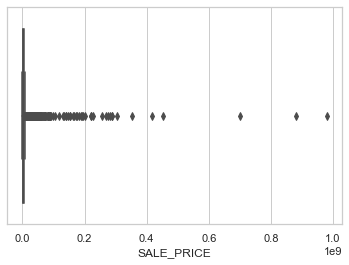

In [19]:
sns.set(style='whitegrid')
ax = sns.boxplot(df.SALE_PRICE)

As we can see, there are two many outliers and the distribution is not "pretty".
So let's write a funtion of checking outliers.

In [20]:
def isoutlier(x, w=1.5):
    
    q1, q3 = np.percentile(x, [25, 75])
    iqr = q3 - q1
    lower = q1 - w * (iqr)
    upper = q3 + w * (iqr)

    return np.logical_or(x < lower, x > upper)

Remove outliers to make the distribution "pretty".

In [21]:
while df[~isoutlier(df.SALE_PRICE)].shape[0] != df.shape[0]:
    print('Remove outliers.')
    df = df[~isoutlier(df.SALE_PRICE)]

Remove outliers.
Remove outliers.
Remove outliers.
Remove outliers.
Remove outliers.
Remove outliers.
Remove outliers.
Remove outliers.
Remove outliers.


Then look at the box plot again.

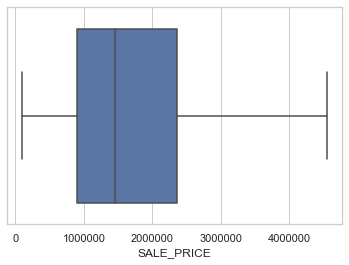

In [22]:
ax = sns.boxplot(df.SALE_PRICE)

Also plot the histogram. Much better distribution, isn't it?

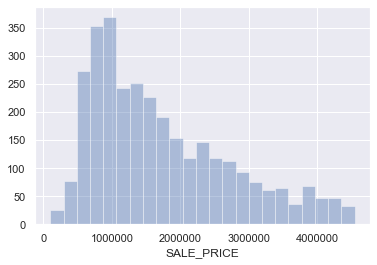

In [23]:
sns.set()
ax = sns.distplot(df.SALE_PRICE, kde=False)

After cleaning, let's the shape of our dataframe.

In [24]:
print(df.shape)
df.head()

(3185, 19)


,BBL,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AS_OF_FINAL_ROLL,BUILDING_CLASS_AS_OF_FINAL_ROLL,ADDRESS,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_MONTH,SALE_DAY,Latitude,Longitude,SALE_PRICE
6,1-390-64,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,C4,187 EAST 7TH STREET,10009,8.0,2.0,10.0,5220.0,1910,2,C4,5,138,40.724964,-73.980594,2400000
11,1-400-54,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,C7,207 EAST 4TH STREET,10009,8.0,3.0,11.0,7166.0,1900,2,C7,5,138,40.723957,-73.983706,3000000
13,1-402-36,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,C4,106 AVENUE B,10009,8.0,2.0,10.0,7810.0,1900,2,C4,5,138,40.724970,-73.981511,3100000
16,1-378-1004,ALPHABET CITY,13 CONDOS - ELEVATOR APARTMENTS,2,R4,399 EAST 8TH STREET,10009,1.0,0.0,1.0,481.0,2014,2,R4,7,206,40.724426,-73.977558,732376
17,1-378-1010,ALPHABET CITY,13 CONDOS - ELEVATOR APARTMENTS,2,R4,399 EAST 8TH STREET,10009,1.0,0.0,1.0,733.0,2014,2,R4,10,282,40.724426,-73.977558,1016213


From now on, we call Foursquare APIs and collect venue information for each BBL (real property). Define the ID and secret of Foursquare.

In [ ]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20190812' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Explore the real properties in Manhattan. Borrow the following function from Week 3.

In [ ]:
LIMIT = 20
radius = 100

def getNearbyVenues(bbls, latitudes, longitudes, radius=100):
    
    venues_list=[]
    for bbl, lat, lng in zip(bbls, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            bbl, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['BBL', 
                  'BBL Latitude', 
                  'BBL Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Collect venue information for each BBL. This may take some time and consumes the daily calls of Foursquare APIs.

In [25]:
df_venues = getNearbyVenues(bbls=df['BBL'],
                            latitudes=df['Latitude'],
                            longitudes=df['Longitude'])

print(df_venues.shape)
df_venues.head()

(26508, 7)


,BBL,BBL Latitude,BBL Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,1-390-64,40.724964,-73.980594,Sunny & Annie Gourmet Deli,40.724590,-73.981600,Deli / Bodega
1,1-390-64,40.724964,-73.980594,Sake Bar Satsko,40.724647,-73.980190,Sake Bar
2,1-390-64,40.724964,-73.980594,C & B Cafe,40.725184,-73.981525,Coffee Shop
3,1-390-64,40.724964,-73.980594,Gruppo,40.724745,-73.981486,Pizza Place
4,1-390-64,40.724964,-73.980594,SOS Chefs,40.724876,-73.981384,Gourmet Shop


In [26]:
print('There are {} uniques categories.'.format(len(df_venues['Venue Category'].unique())))

There are 349 uniques categories.


Generate one-hot features for the categorical variable.

In [27]:
df_onehot = pd.get_dummies(df_venues[['Venue Category']], prefix='', prefix_sep='')
df_onehot['BBL'] = df_venues['BBL']
print(df_onehot.shape)
df_onehot.head()

(26508, 350)


,Accessories Store,Acupuncturist,Adult Boutique,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,...,Vietnamese Restaurant,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,BBL
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1-390-64
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1-390-64
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1-390-64
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1-390-64
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1-390-64


Group by BBL and average each category.

In [28]:
df_grouped = df_onehot.groupby('BBL').mean().reset_index()
print(df_grouped.shape)
df_grouped.head()

(3079, 350)


,BBL,Accessories Store,Acupuncturist,Adult Boutique,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,...,Video Store,Vietnamese Restaurant,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,1-1005-1019,0.0,0.0,0.0,0.0,0.111111,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.111111,0.0,0.0,0.0,0.0
1,1-1005-1020,0.0,0.0,0.0,0.0,0.111111,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.111111,0.0,0.0,0.0,0.0
2,1-1006-1009,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,1-1006-1042,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,1-1006-1106,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


Borrow the function from Week 3, and look at top 5 common venues for each BBL.

In [29]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['BBL']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
df_venues_sorted = pd.DataFrame(columns=columns)
df_venues_sorted['BBL'] = df_grouped['BBL']

for ind in np.arange(df_grouped.shape[0]):
    df_venues_sorted.iloc[ind, 1:] = return_most_common_venues(df_grouped.iloc[ind, :], num_top_venues)
    
print(df_venues_sorted.shape)
df_venues_sorted.head()

(3079, 6)


,BBL,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,1-1005-1019,Bakery,Deli / Bodega,Steakhouse,Seafood Restaurant,French Restaurant
1,1-1005-1020,Bakery,Deli / Bodega,Steakhouse,Seafood Restaurant,French Restaurant
2,1-1006-1009,Bakery,Outdoor Sculpture,Hotel,Italian Restaurant,Food Truck
3,1-1006-1042,Bakery,Outdoor Sculpture,Hotel,Italian Restaurant,Food Truck
4,1-1006-1106,Bakery,Outdoor Sculpture,Hotel,Italian Restaurant,Food Truck


Until now, we extract venue information for each BBL. Now let's go back to the property data and transform categorical variables into one-hot features.

In [30]:
cat_col_name = 'TAX_CLASS_AT_TIME_OF_SALE'
df_tax_onehot = pd.get_dummies(df[cat_col_name], prefix=cat_col_name)
df_tax_onehot.head()

,TAX_CLASS_AT_TIME_OF_SALE_1,TAX_CLASS_AT_TIME_OF_SALE_2,TAX_CLASS_AT_TIME_OF_SALE_4
6,0,1,0
11,0,1,0
13,0,1,0
16,0,1,0
17,0,1,0


In [31]:
cat_col_name = 'BUILDING_CLASS_AT_TIME_OF_SALE'
df_building_onehot = pd.get_dummies(df[cat_col_name], prefix=cat_col_name)
df_building_onehot.head()

,BUILDING_CLASS_AT_TIME_OF_SALE_A1,BUILDING_CLASS_AT_TIME_OF_SALE_A4,BUILDING_CLASS_AT_TIME_OF_SALE_A9,BUILDING_CLASS_AT_TIME_OF_SALE_B1,BUILDING_CLASS_AT_TIME_OF_SALE_B2,BUILDING_CLASS_AT_TIME_OF_SALE_B3,BUILDING_CLASS_AT_TIME_OF_SALE_B9,BUILDING_CLASS_AT_TIME_OF_SALE_C0,BUILDING_CLASS_AT_TIME_OF_SALE_C1,BUILDING_CLASS_AT_TIME_OF_SALE_C2,...,BUILDING_CLASS_AT_TIME_OF_SALE_RA,BUILDING_CLASS_AT_TIME_OF_SALE_RG,BUILDING_CLASS_AT_TIME_OF_SALE_RH,BUILDING_CLASS_AT_TIME_OF_SALE_RK,BUILDING_CLASS_AT_TIME_OF_SALE_RR,BUILDING_CLASS_AT_TIME_OF_SALE_S1,BUILDING_CLASS_AT_TIME_OF_SALE_S2,BUILDING_CLASS_AT_TIME_OF_SALE_S3,BUILDING_CLASS_AT_TIME_OF_SALE_S4,BUILDING_CLASS_AT_TIME_OF_SALE_S5
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Let's add the generated one-hot features back.

In [32]:
df = pd.concat([df, df_tax_onehot, df_building_onehot], axis=1)
print(df.shape)
df.head()

(3185, 69)


,BBL,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AS_OF_FINAL_ROLL,BUILDING_CLASS_AS_OF_FINAL_ROLL,ADDRESS,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,...,BUILDING_CLASS_AT_TIME_OF_SALE_RA,BUILDING_CLASS_AT_TIME_OF_SALE_RG,BUILDING_CLASS_AT_TIME_OF_SALE_RH,BUILDING_CLASS_AT_TIME_OF_SALE_RK,BUILDING_CLASS_AT_TIME_OF_SALE_RR,BUILDING_CLASS_AT_TIME_OF_SALE_S1,BUILDING_CLASS_AT_TIME_OF_SALE_S2,BUILDING_CLASS_AT_TIME_OF_SALE_S3,BUILDING_CLASS_AT_TIME_OF_SALE_S4,BUILDING_CLASS_AT_TIME_OF_SALE_S5
6,1-390-64,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,C4,187 EAST 7TH STREET,10009,8.0,2.0,10.0,...,0,0,0,0,0,0,0,0,0,0
11,1-400-54,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,C7,207 EAST 4TH STREET,10009,8.0,3.0,11.0,...,0,0,0,0,0,0,0,0,0,0
13,1-402-36,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,C4,106 AVENUE B,10009,8.0,2.0,10.0,...,0,0,0,0,0,0,0,0,0,0
16,1-378-1004,ALPHABET CITY,13 CONDOS - ELEVATOR APARTMENTS,2,R4,399 EAST 8TH STREET,10009,1.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
17,1-378-1010,ALPHABET CITY,13 CONDOS - ELEVATOR APARTMENTS,2,R4,399 EAST 8TH STREET,10009,1.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0


Now let's define a new dataframe for building the predictive model.

In [33]:
df_learning = pd.merge(df, df_grouped, on='BBL')
print(df_learning.shape)
df_learning.head()

(3079, 418)


,BBL,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AS_OF_FINAL_ROLL,BUILDING_CLASS_AS_OF_FINAL_ROLL,ADDRESS,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,...,Video Store,Vietnamese Restaurant,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,1-390-64,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,C4,187 EAST 7TH STREET,10009,8.0,2.0,10.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,1-400-54,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,C7,207 EAST 4TH STREET,10009,8.0,3.0,11.0,...,0.0,0.090909,0.0,0.0,0.0,0.090909,0.0,0.0,0.0,0.0
2,1-402-36,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,C4,106 AVENUE B,10009,8.0,2.0,10.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,1-378-1004,ALPHABET CITY,13 CONDOS - ELEVATOR APARTMENTS,2,R4,399 EAST 8TH STREET,10009,1.0,0.0,1.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,1-378-1010,ALPHABET CITY,13 CONDOS - ELEVATOR APARTMENTS,2,R4,399 EAST 8TH STREET,10009,1.0,0.0,1.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


Drop any unnecessary columns that are not related to predict housing price.

In [34]:
sale_price = df_learning['SALE_PRICE'].values
df_learning.drop(columns=['NEIGHBORHOOD', 
                          'BUILDING_CLASS_CATEGORY',
                          'TAX_CLASS_AS_OF_FINAL_ROLL',
                          'BUILDING_CLASS_AS_OF_FINAL_ROLL', 
                          'ADDRESS', 
                          'ZIP_CODE',
                          'TAX_CLASS_AT_TIME_OF_SALE', 
                          'BUILDING_CLASS_AT_TIME_OF_SALE',
                          'SALE_PRICE'], inplace=True)
df_learning['SALE_PRICE'] = sale_price

print(df_learning.shape)
df_learning.head()

(3079, 410)


,BBL,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,SALE_MONTH,SALE_DAY,Latitude,Longitude,...,Vietnamese Restaurant,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,SALE_PRICE
0,1-390-64,8.0,2.0,10.0,5220.0,1910,5,138,40.724964,-73.980594,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,2400000
1,1-400-54,8.0,3.0,11.0,7166.0,1900,5,138,40.723957,-73.983706,...,0.090909,0.0,0.0,0.0,0.090909,0.0,0.0,0.0,0.0,3000000
2,1-402-36,8.0,2.0,10.0,7810.0,1900,5,138,40.724970,-73.981511,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,3100000
3,1-378-1004,1.0,0.0,1.0,481.0,2014,7,206,40.724426,-73.977558,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,732376
4,1-378-1010,1.0,0.0,1.0,733.0,2014,10,282,40.724426,-73.977558,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1016213


Extract training data from the prepared dataframe.

In [35]:
X = df_learning.iloc[:, 1:-1]
y = df_learning.iloc[:, -1]

Split into training and test datasets.

In [36]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

Define the regression model. Here we choose Gradient Boosting Trees and define the parameter grid for model selection.

In [37]:
reg_gb = GradientBoostingRegressor(random_state=42)
param_grid = {'learning_rate': np.logspace(-3, 0, num=4),
              'n_estimators': np.arange(100, 401, 20),
              'max_depth': np.arange(3, 13)}
reg_gb_cv = GridSearchCV(reg_gb, param_grid, cv=5, n_jobs=-1, verbose=10)

Fit the model using training data. This takes a very long time due to the grid search.

In [ ]:
reg_gb_cv.fit(X_train, y_train)

## Results

After the training is finished, let's check the best parameters and score.

In [39]:
reg_gb_cv.best_params_, reg_gb_cv.best_score_

({'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 280},
 0.7665341547371686)

Prediction on the test data and evaluation using metrics RMSE and R2.

In [40]:
y_pred = reg_gb_cv.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred)), r2_score(y_test, y_pred)

(472209.8888819147, 0.7843457393941258)

The final model has the RMSE 472210 and R2 0.78, which is not bad. Now let's further interpret the resulting model. First, let's have a look at what are important features that affect the housing price most. Specifically, top 10 features are listed.

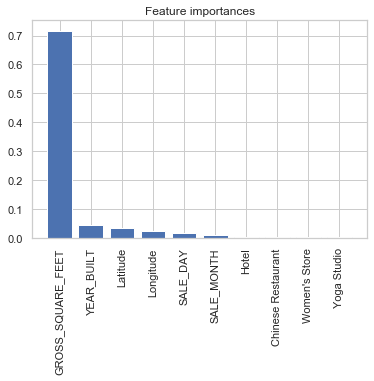

In [41]:
feature_importances = reg_gb_cv.best_estimator_.feature_importances_
idx_features = np.argsort(feature_importances)[::-1]
n_top = 10

sns.set(style='whitegrid')
plt.figure()
plt.title("Feature importances")
plt.bar(range(n_top), feature_importances[idx_features[:n_top]])
plt.xticks(range(n_top), idx_features[:n_top])
ax = plt.gca()
ax.set_xticklabels(X_train.columns[idx_features[:n_top]], rotation = 90)
plt.show()

Moreover, we can create the Partial Dependence Plots (PDPs) to see how do top features affect the prediction. We plot PDPs for top 6 features. 

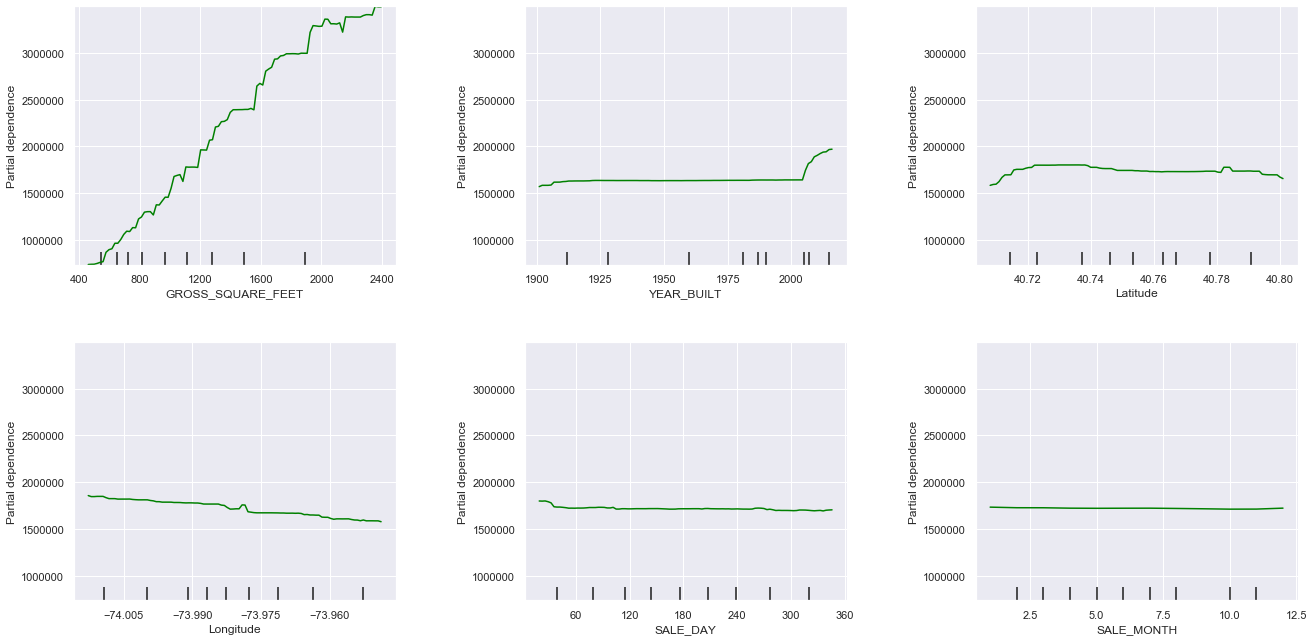

In [42]:
sns.set()
n_top = 6
fig = plt.figure(figsize=(20, 15))
plot_partial_dependence(reg_gb_cv, X_train, 
                        features=idx_features[:n_top], 
                        feature_names=X_train.columns.to_list(), 
                        fig=fig)

## Discussion

The performance of the predictive model is not bad, but there is still room for improvement. For example, we can come up with new ways of crafting features, and also try other regression models. However, if we switch to some black-box models, we won't have the interpretability about the features, as we show in the last section. Anyway, it all depends on the user about which model to choose: more accurate or more interpretable.

Regarding the feature importances, it's not surprising that "GROSS_SQUARE_FEET" is the most important that affects the housing price. It is followed by the year when the house was built and then its location (Lat & Lng). As for one-hot features, the most effective ones are "Hotel", "Chinese Restaurant", "Women's Store", and "Yoga Studio".

The partial dependence plots show how the top features affect the housing price. It's easy to see "GROSS_SQUARE_FEET" has a positive correlation to the price, which is natural. Interestingly, there is a jump at around 2000 in the PDP of "YEAR_BUILT", which implies the price of houses built after 2000 depends on "YEAR_BUILT" more than the ones earlier.

## Conclusion

In this project, we built a predictive model for housing price in Manhattan, 2018. We mainly used three data sets: the properties sales data from the NYC government, the geographical data from OpenStreetMap, and the neighborhood venue data from Foursquare. We first preprocessed the data, and combined them into a dataset which is in a favored form for training a regression model. Then we chose Gradient Boosting Trees as our target and conducted model selection using grid search. After training, we ended up with a predictive model with an R2 score 0.78, which is not bad. Finally, we interpreted and visualized the resulting model and found the important and interesting features that affect the housing price prediction, such as "GROSS_SQUARE_FEET".